# Notebook for the analysis of XPS data 

Analysis of `dati/Al_Sm_50V_3d.csv`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from arpes.io import load_data
import xarray as xr


/Users/a129544/anaconda3/envs/XPS/lib/python3.8/site-packages/arpes/config.py:54: UserWarning: Could not find local configuration file. If you don't have one, you can safely ignore this message.
  warnings.warn(msg)


Activating auto-logging. Current session state plus future input saved.
Filename       : logs/unnamed_2023-06-10_16-52-04.log
Mode           : backup
Output logging : False
Raw input log  : False
Timestamping   : False
State          : active


In [2]:
def load_csv_datatype(path_to_file: str, 
                      n_scans: int= 1,
                      energy_key: str = 'Energy(meas)',
                      dim_name: str = 'eV') -> xr.DataArray:
    """
    This function load a dataset in the csv format using pandas.
    the number of scans need to be manually insered. 
    If multiple scans are present the mean is considered 
    """

    df = pd.read_csv(path_to_file, skiprows=1, sep='\t')

    scan_list = [f'Scan{i}' for i in range(1,n_scans+1)]
    loaded_data = df[scan_list].mean(axis=1).to_numpy()
    
    #loaded_data = [df[key].to_numpy().T for key in scan_list]

    coords = {dim_name : df[energy_key].to_numpy()}

    return xr.DataArray(
        loaded_data,
        coords=coords,
        dims=dim_name,
        # attrs={...} <- attributes here
    )

# Load datas 
In  order to load the datas and to insert them in the `xr.DataArray` object we use a custom function. 
First we analyze the datas importing them with pandas, then we can load them using the function `load_csv_datatype`. This function allow to load datas in the correct format for the successives analysis.

In [3]:
data_path = 'dati/Al_Sm_50V_3d.csv'

df = pd.read_csv(data_path, skiprows=1, sep='\t')
df

,Energy(calc),Energy(meas),Sum,Scan1,Scan2,Scan3,Scan4,Scan5,Scan6,Scan7
0,440.0,438.49,20813,2119,2985,3202,3163,3123,3203,3018
1,439.7,438.22,19616,1957,2872,2913,2921,2969,3045,2939
2,439.4,437.96,19676,2060,2830,2885,3051,3052,2844,2954
3,439.1,437.69,19858,2171,2886,2905,3023,2982,2941,2950
4,438.8,437.39,20030,2219,2875,3084,3099,2969,2960,2824
...,...,...,...,...,...,...,...,...,...,...
263,361.2,360.49,31496,4426,4541,4549,4383,4497,4477,4623
264,360.9,360.25,31192,4392,4451,4570,4354,4623,4276,4526
265,360.6,359.95,31241,4394,4522,4516,4523,4426,4360,4500
266,360.3,359.66,31319,4291,4430,4510,4502,4599,4454,4533


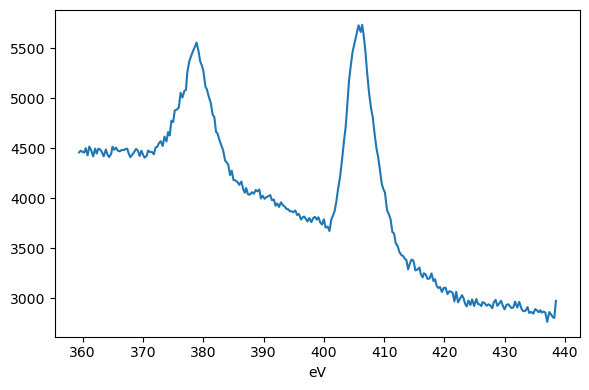

In [4]:
data = load_csv_datatype(path_to_file=data_path, n_scans=7)

# Plot datas
fig, axes = plt.subplots(1, 1, figsize=(6,4))

#data.sum("eV").S.plot(ax=axes)
data.S.plot(ax=axes)

plt.tight_layout()

# Curve fitting 

First let's try just to fit the model without subtract the background 

/var/folders/lg/r7smz1g54tj4bqh1js51y8kc0000gn/T/ipykernel_15208/3547394423.py:7: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  selection = df['Energy(meas)'].between(370, 414, inclusive=False).to_numpy()


name,value,min,max,stderr,vary,expr,brute_step
a_amplitude,17834.706,-inf,inf,453.864,True,,
a_center,405.924,400.000,410.000,0.055,True,,
a_fwhm,4.748,-inf,inf,0.165,False,2.0000000*a_sigma,
a_height,2391.370,-inf,inf,55.960,False,"0.3183099*a_amplitude/max(1e-15, a_sigma)",
a_sigma,2.374,0.000,inf,0.083,True,,
b_amplitude,45844.105,-inf,inf,1060.039,True,,
b_center,378.078,378.000,382.000,0.051,True,,
b_fwhm,15.185,-inf,inf,0.502,False,2.0000000*b_sigma,
b_height,1921.924,-inf,inf,34.345,False,"0.3183099*b_amplitude/max(1e-15, b_sigma)",
b_sigma,7.593,0.000,inf,0.251,True,,


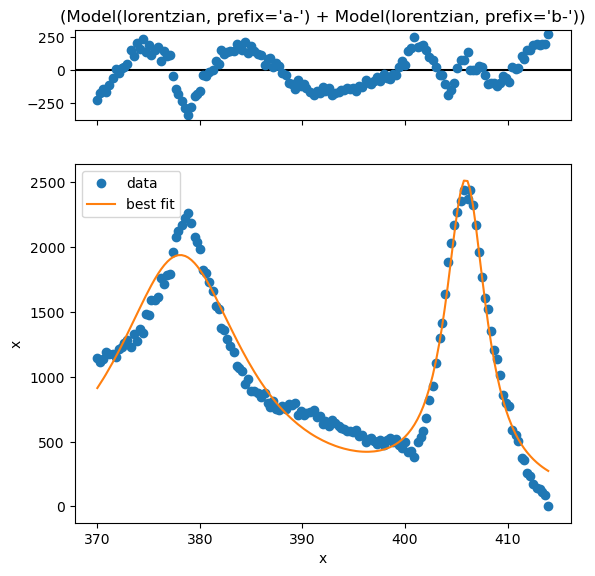

In [5]:
from arpes.fits.fit_models import GaussianModel, AffineBackgroundModel, LorentzianModel, VoigtModel
from arpes.analysis.shirley import remove_shirley_background, calculate_shirley_background_full_range
from arpes.fits.utilities import result_to_hints
#test_curve = data.spectrum.where(ws2_mask & ~wide_peak_mask).mean(["x", "y"]).sel(eV=slice(-36, -31))

# Selection
selection = df['Energy(meas)'].between(370, 414, inclusive=False).to_numpy()

test_curve = data.sel(eV=selection)

test_model =  LorentzianModel(prefix="a_") + LorentzianModel(prefix="b_")

result = test_model.guess_fit(
    test_curve - test_curve.min(),
    params={
        "a_center": {"value": 405, "max":410, "min":400 },
        "b_center": {"value": 375, "max":382, "min":378},
    }
)
result.plot()
result

/var/folders/lg/r7smz1g54tj4bqh1js51y8kc0000gn/T/ipykernel_15208/2223888770.py:4: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  selection = df['Energy(meas)'].between(370, 415, inclusive=False).to_numpy()


name,value,min,max,stderr,vary,expr,brute_step
a_amplitude,17560.450,0.000,inf,inf,True,,
a_center,406.402,-inf,inf,inf,True,,
a_fwhm,4.864,-inf,inf,inf,False,2.0000000*a_sigma,
a_height,2298.588,-inf,inf,inf,False,"0.3183099*a_amplitude/max(1e-15, a_sigma)",
a_sigma,2.432,1.400,2.500,inf,True,,
b_amplitude,17458.317,0.000,inf,inf,True,,
b_center,379.241,-inf,inf,inf,True,,
b_fwhm,7.542,-inf,inf,inf,False,2.0000000*b_sigma,
b_height,1473.572,-inf,inf,inf,False,"0.3183099*b_amplitude/max(1e-15, b_sigma)",
b_sigma,3.771,0.000,inf,inf,True,,


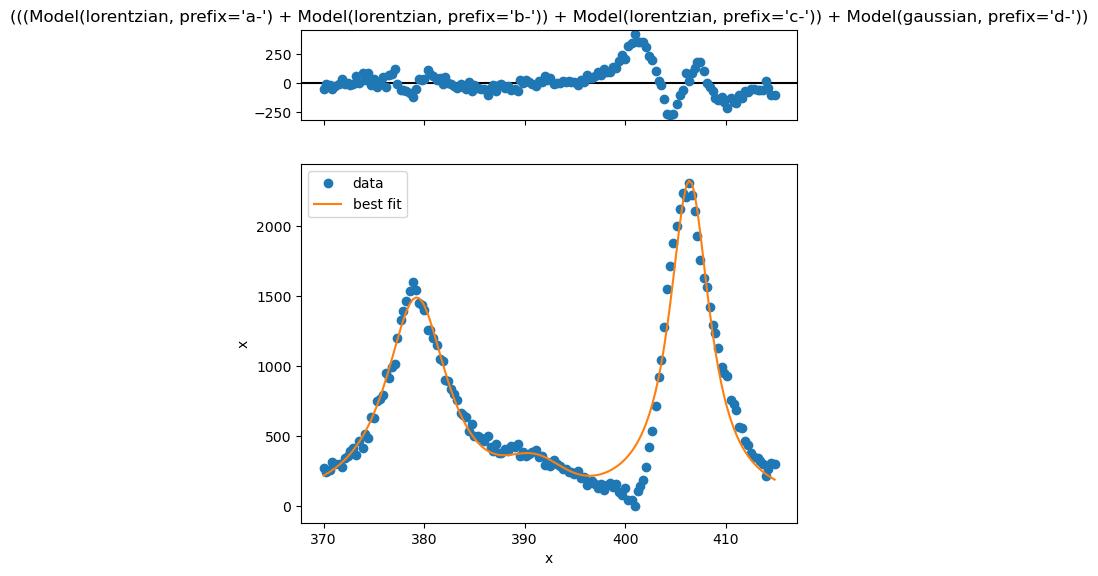

In [6]:
# test_curve = xps.spectrum.where(mask).mean(["x", "y"]).sel(eV=slice(-36, -31))
# test_curve = remove_shirley_background(test_curve)

selection = df['Energy(meas)'].between(370, 415, inclusive=False).to_numpy()
test_curve = data.sel(eV=selection)
#test_curve = remove_shirley_background(test_curve)

test_curve = test_curve - calculate_shirley_background_full_range(test_curve, max_iters=100)

test_model = LorentzianModel(prefix="a_") + LorentzianModel(prefix="b_") + LorentzianModel(prefix="c_") + GaussianModel(prefix="d_")

result = test_model.guess_fit(
    test_curve-test_curve.min(),
    params={
        "a_center": {"value": 405 },
        "a_sigma": {"value": 1.5, "max": 2.5, "min": 1.4},
        "a_amplitude": {"min": 0},
        "b_center": {"value": 375},
        "b_amplitude": {"min": 0},
        "c_center": {"value": 398, "max": 399, "min":397},
        "c_amplitude": {"min": 0.3},
        "c_sigma":{"max": 3, "min": 1},
        "d_center": {"value": 393, "max": 396, "min":391},
        "d_amplitude": {"min": 0},
        "d_sigma":{"max": 10, "min": 1},
    }

)
result.plot()
result

/var/folders/lg/r7smz1g54tj4bqh1js51y8kc0000gn/T/ipykernel_15208/731265355.py:1: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  selection = df['Energy(meas)'].between(370, 415, inclusive=False).to_numpy()


name,value,min,max,stderr,vary,expr,brute_step
a_amplitude,11045.534,0.000,inf,inf,True,,
a_center,406.033,-inf,inf,inf,True,,
a_fwhm,4.761,-inf,inf,inf,False,2.3548200*a_sigma,
a_height,2179.590,-inf,inf,inf,False,"0.3989423*a_amplitude/max(1e-15, a_sigma)",
a_sigma,2.022,1.400,2.500,inf,True,,
b_amplitude,8237.836,0.000,inf,inf,True,,
b_center,379.336,-inf,inf,inf,True,,
b_fwhm,6.598,-inf,inf,inf,False,2.3548200*b_sigma,
b_height,1172.876,-inf,inf,inf,False,"0.3989423*b_amplitude/max(1e-15, b_sigma)",
b_sigma,2.802,0.000,inf,inf,True,,


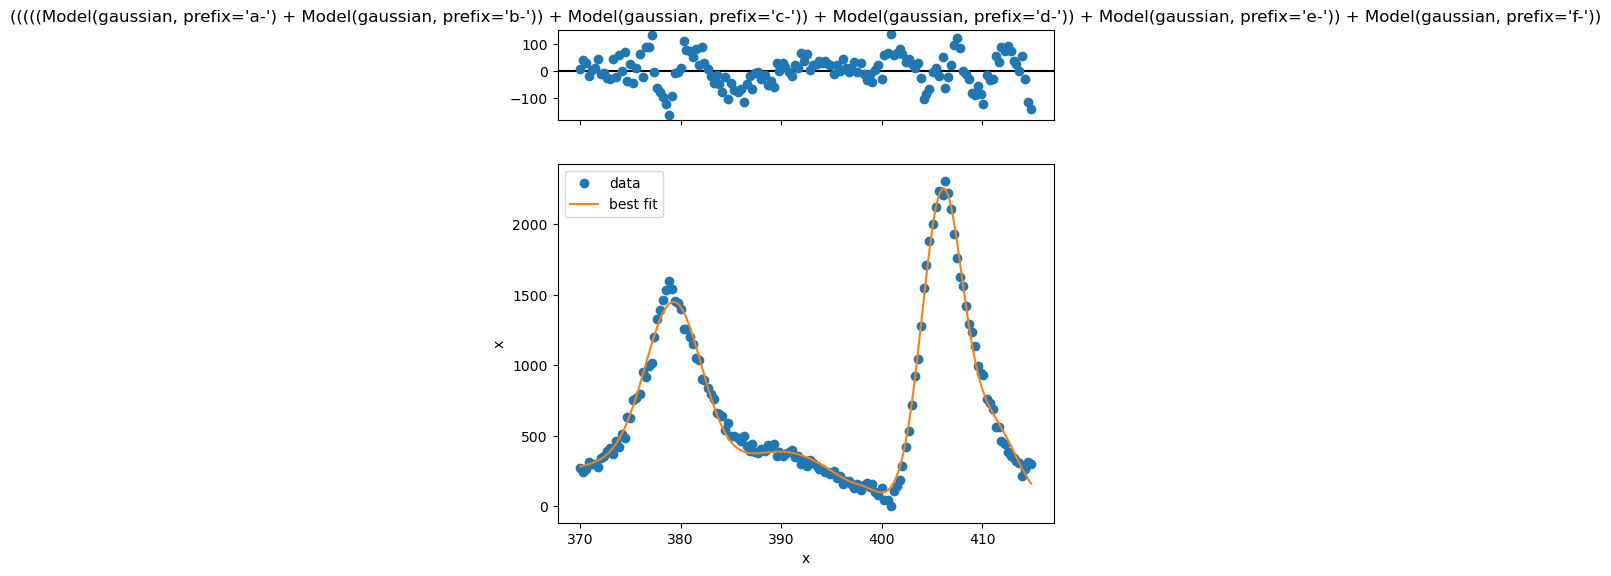

In [12]:
selection = df['Energy(meas)'].between(370, 415, inclusive=False).to_numpy()
test_curve = data.sel(eV=selection)


test_curve = test_curve - calculate_shirley_background_full_range(test_curve, max_iters=100)

test_model = GaussianModel(prefix="a_") + GaussianModel(prefix="b_") + GaussianModel(prefix="c_") + GaussianModel(prefix="d_") + GaussianModel(prefix="e_") + GaussianModel(prefix="f_")

result = test_model.guess_fit(
    test_curve-test_curve.min(),
    params={
        "a_center": {"value": 405 },
        "a_sigma": {"value": 1.5, "max": 2.5, "min": 1.4},
        "a_amplitude": {"min": 0},
        "b_center": {"value": 375},
        "b_amplitude": {"min": 0},
        "c_center": {"value": 398, "max": 399, "min":397},
        "c_amplitude": {"min": 0.3},
        "c_sigma":{"max": 3, "min": 1},
        "d_center": {"value": 393, "max": 396, "min":391},
        "d_amplitude": {"min": 0},
        "d_sigma":{"max": 10, "min": 1},
        "e_center": {"value": 413, "max": 415, "min":411},
        "e_amplitude": {"min": 0},
        "e_sigma":{"max": 10, "min": 1},
        "f_center": {"value": 373, "max": 374, "min":370},
        "f_amplitude": {"min": 0},
        "f_sigma":{"max": 10, "min": 1},
    }

)
result.plot()
result

In [13]:
print(result.fit_report())

[[Model]]
    (((((Model(gaussian, prefix='a_') + Model(gaussian, prefix='b_')) + Model(gaussian, prefix='c_')) + Model(gaussian, prefix='d_')) + Model(gaussian, prefix='e_')) + Model(gaussian, prefix='f_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5123
    # data points      = 152
    # variables        = 18
    chi-square         = 486144.958
    reduced chi-square = 3627.94745
    Akaike info crit   = 1262.69800
    Bayesian info crit = 1317.12785
    R-squared          = 0.98964807
##  Warning: uncertainties could not be estimated:
    c_sigma:      at initial value
    c_sigma:      at boundary
    d_center:     at boundary
    e_center:     at boundary
    f_center:     at boundary
    f_sigma:      at boundary
[[Variables]]
    a_amplitude:  11045.5343 (init = 0)
    a_center:     406.033175 (init = 405)
    a_sigma:      2.02172512 (init = 1.5)
    b_amplitude:  8237.83617 (init = 0)
    b_center:     379.336399 (init = 375)
    b_sigma:     